In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def split_image(image_pair):
    height, width_pair = image_pair.shape
    width = int(width_pair/2)

    image_left = image_pair[0:height, 0:width]
    image_right = image_pair[0:height, width:width_pair]
    
    return image_left, image_right, (width, height)

def get_corners (image_search, checker_def, scale_ratio = 1):
    columns = checker_def[0]
    rows = checker_def[1]
    square_size = checker_def[2]
    
    object_point = np.zeros((columns*rows, 3), dtype=np.float32)
    object_point[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)
    object_point *= square_size

    # Arrays to store object points and image points from all the images.
    object_points = [] # 3d point in real world space
    left_image_points = [] # 2d points in left camera image plane.
    right_image_points = [] # 2d points in right camera image plane.

    images = glob.glob(image_search)

    for image_filename in images:
        image_pair = cv2.imread(image_filename, cv2.IMREAD_COLOR)
        image_pair = cv2.cvtColor(image_pair,cv2.COLOR_BGR2GRAY)
        image_left, image_right, (width, height) = split_image(image_pair)

        # Find the chess board corners
        flags = cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE
        retL, cornersL = cv2.findChessboardCorners(image_left, (columns, rows), flags)
        retR, cornersR = cv2.findChessboardCorners(image_right, (columns, rows), flags)

        if ((retL == True) and (retR == True)):
            cornersL = cornersL*scale_ratio 
            cornersR = cornersR*scale_ratio
            
            scaled_width = int(width*scale_ratio)
            scaled_height = int(height*scale_ratio)

            resized_image_left = cv2.resize (image_left, (scaled_width,scaled_height), interpolation = cv2.INTER_AREA)
            resized_image_right = cv2.resize (image_right, (scaled_width,scaled_height), interpolation = cv2.INTER_AREA)
                     
            object_points.append(object_point)           
            
            subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
            cornersL = cv2.cornerSubPix(resized_image_left, cornersL, (3,3), (-1,-1), subpix_criteria)
            left_image_points.append(cornersL)
            cornersR = cv2.cornerSubPix(resized_image_right, cornersR, (3,3), (-1,-1), subpix_criteria)
            right_image_points.append(cornersR)
            
    return object_points, left_image_points, right_image_points, (width, height)

def calibrate_cameras(object_points, left_image_points, right_image_points, image_dims):
        
    if (os.path.isdir('./calibration_data')==False):
        print("Creating calibration results directory")
        os.makedirs('./calibration_data')
                    
    # Calibrate Left Camera
    print("Calibrating Left Camera...")
    (rms_left, left_camera_matrix, 
     left_dist_coeffs, _, _) = cv2.calibrateCamera(objectPoints=object_points,
                                                   imagePoints=left_image_points,
                                                   imageSize=image_dims,
                                                   cameraMatrix=None,
                                                   distCoeffs=None)
    print(rms_left)
    print(left_camera_matrix)
    print(left_dist_coeffs)
                    
    np.savez('./calibration_data/camera_calibration_left.npz', object_points=object_points, image_points=left_image_points,
        camera_matrix=left_camera_matrix, distortion_coeff=left_dist_coeffs)

    # Calibrate Right Camera
    print("Calibrating Right Camera...")
    (rms_right, right_camera_matrix, 
     right_dist_coeffs, _, _) = cv2.calibrateCamera(objectPoints=object_points,
                                                   imagePoints=right_image_points,
                                                   imageSize=image_dims,
                                                   cameraMatrix=None,
                                                   distCoeffs=None) 
    print(rms_right)
    print(right_camera_matrix)
    print(right_dist_coeffs)
     
    np.savez('./calibration_data/camera_calibration_right.npz', object_points=object_points, image_points=right_image_points,
        camera_matrix=right_camera_matrix, distortion_coeff=right_dist_coeffs)

    # Stereo Calibrate
    print ("Stereo Calibrate....")
    (rms_stereo, _, _, _, _,
     R, T, E, F) = cv2.stereoCalibrate(objectPoints=object_points,
                                       imagePoints1=left_image_points,
                                       imagePoints2=right_image_points,
                                       cameraMatrix1=left_camera_matrix,
                                       distCoeffs1=left_dist_coeffs,
                                       cameraMatrix2=right_camera_matrix,
                                       distCoeffs2=right_dist_coeffs,
                                       imageSize=image_dims)
     
    print(rms_stereo)

     # Compute parameters to rectify each camera.
    (rect_trans_left, rect_trans_right, 
     proj_matrix_left, proj_matrix_right, 
     Q, boxes_left, boxes_right) = cv2.stereoRectify(cameraMatrix1=left_camera_matrix,
                                                     distCoeffs1=left_dist_coeffs,
                                                     cameraMatrix2=right_camera_matrix,
                                                     distCoeffs2=right_dist_coeffs,
                                                     imageSize=image_dims,
                                                     R=R,
                                                     T=T)
    
    print(Q)
     
    # Compute the undistort maps
    left_map_1, left_map_2 = cv2.initUndistortRectifyMap(cameraMatrix=left_camera_matrix,
                                                        distCoeffs=left_dist_coeffs,
                                                        R=rect_trans_left,
                                                        newCameraMatrix=proj_matrix_left,
                                                        size=image_dims,
                                                        m1type=cv2.CV_32FC1)

    right_map_1, right_map_2 = cv2.initUndistortRectifyMap(cameraMatrix=right_camera_matrix,
                                                    distCoeffs=right_dist_coeffs,
                                                    R=rect_trans_right,
                                                    newCameraMatrix=proj_matrix_right,
                                                    size=image_dims,
                                                    m1type=cv2.CV_32FC1)
    np.savez_compressed('./calibration_data/stereo_camera_calibration.npz', imageSize=image_dims,
            R=R, T=T, E=E, F=F, Q=Q, left_map_1=left_map_1, left_map_2=left_map_2,
            right_map_1=right_map_1, right_map_2=right_map_2)
    
    return left_map_1, left_map_2, right_map_1, right_map_2, Q

In [3]:
image_search = './calibrate_images/*.png'
checker_def = (9,6,40)
scale_ratio = 0.5

object_points, left_image_points, right_image_points, image_dims = get_corners (image_search, checker_def, scale_ratio)

In [4]:
scaled_image_dims = (int(image_dims[0]*scale_ratio), int(image_dims[1]*scale_ratio))

left_map_1, left_map_2, right_map_1, right_map_2, Q = calibrate_cameras(object_points, left_image_points, right_image_points, scaled_image_dims)

Calibrating Left Camera...
0.10817302482162608
[[316.5971768    0.         154.25497779]
 [  0.         318.02093241 118.64072686]
 [  0.           0.           1.        ]]
[[ 2.65913078e-01 -6.64866723e-01  1.23642329e-04 -1.68039688e-03
  -3.34851919e-03]]
Calibrating Right Camera...
0.10239977953849619
[[322.10050296   0.         161.76425372]
 [  0.         323.6592749  122.41466322]
 [  0.           0.           1.        ]]
[[ 1.99451327e-01 -2.12229779e-01 -4.68194262e-04  1.22593815e-03
  -1.19143822e+00]]
Stereo Calibrate....
0.11038568445467391
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.53756018e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.20883785e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.20840104e+02]
 [ 0.00000000e+00  0.00000000e+00  1.53334276e-02 -0.00000000e+00]]


(240, 320)


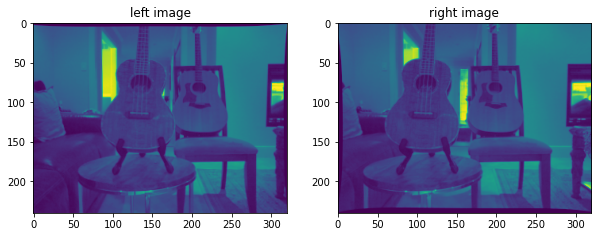

In [5]:
image_filename = './dm-tune.jpg'

image_pair = cv2.imread(image_filename, cv2.IMREAD_COLOR)
image_pair = cv2.cvtColor(image_pair,cv2.COLOR_RGB2GRAY)
image_left, image_right, (width, height) = split_image(image_pair)
print(image_left.shape)

rectified_image_left = cv2.remap(image_left, left_map_1, left_map_2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
rectified_image_right = cv2.remap(image_right, right_map_1, right_map_2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

_, image_cells = plt.subplots(1, 2, figsize=(10, 10))
image_cells[0].imshow(rectified_image_left)
image_cells[0].set_title('left image')
image_cells[1].imshow(rectified_image_right)
image_cells[1].set_title('right image')
plt.show()